In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# Physical parameters
D = 5.0
De = 0.01
A = 0.5
epsilon = 0.1
psi = 0.1

# Neural network
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 6)
        )
        
        # Train log_E to ensure positivity of E
        self.log_E = nn.Parameter(torch.tensor(0.0))  # log(1) = 0

        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 0.01)

    def forward(self, x):
        return self.net(x)

    @property
    def E(self):
        """Ensure E remains positive by exponentiating log_E"""
        return torch.exp(self.log_E)  

# Loss function with stable gradient computation
def compute_loss(model, x_coll, x_bc0, x_bc1):
    outputs = model(x_coll)
    u, L, e, tau_xx, tau_yy, tau_zz = torch.split(outputs, 1, dim=1)

    def safe_grad(y, x):
        grad_output = grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True, allow_unused=True)[0]
        return grad_output if grad_output is not None else torch.zeros_like(x)

    grad_u = safe_grad(u, x_coll)
    grad_L = safe_grad(L, x_coll)
    grad_e = safe_grad(e, x_coll)
    grad_tau_xx = safe_grad(tau_xx, x_coll)
    grad_tau_yy = safe_grad(tau_yy, x_coll)
    grad_tau_zz = safe_grad(tau_zz, x_coll)

    # Governing equations
    residual1 = e * L * u - 1.0
    residual2 = (tau_xx - tau_zz) - u

    E = torch.clamp(model.E, min=1e-8)  # Ensures E is always ≥ 1e-8

    trace_stress = tau_xx + tau_yy + tau_zz
    exp_term = (De * epsilon / E) * trace_stress
    exp_term = torch.clamp(exp_term, min=-50, max=50)

    denominator = torch.clamp(tau_xx - tau_zz, min=1e-8)
    ratio = (tau_yy - tau_zz) / denominator
    ratio = torch.clamp(ratio, min=1e-8)

    residual3 = grad_L + A * torch.sqrt(ratio)
    residual4_xx = (
        De * u * grad_tau_xx + grad_u * (-2 * tau_xx * De + 4 * psi * De * tau_xx - 2 * E)
        + tau_xx * torch.exp(exp_term)
    )
    residual4_yy = (
        De * u * grad_tau_yy + grad_L * (-2 * tau_yy * De * u / L + 4 * psi * De * tau_yy / L - 2 * E * u / L)
        + tau_yy * torch.exp(exp_term)
    )
    residual4_zz = (
        De * u * grad_tau_zz + grad_e * (-2 * tau_zz * De * u / e + 4 * psi * De * tau_zz / e - 2 * E * u / e)
        + tau_zz * torch.exp(exp_term)
    )

    # Boundary conditions
    outputs_bc0 = model(x_bc0)
    outputs_bc1 = model(x_bc1)
    bc_loss = ((outputs_bc0[:, 0] - 1.0) ** 2 + (outputs_bc0[:, 1] - 1.0) ** 2 + (outputs_bc0[:, 2] - 1.0) ** 2 +
               (outputs_bc0[:, 3] - 1.0) ** 2 + (outputs_bc0[:, 4] - 0.5) ** 2 + (outputs_bc0[:, 5] - 0.0) ** 2).mean()
    bc_loss += ((outputs_bc1[:, 0] - D) ** 2).mean()

    # Gradient penalty
    grad_penalty = (grad_u.pow(2).mean() + grad_L.pow(2).mean() + grad_e.pow(2).mean() +
                    grad_tau_xx.pow(2).mean() + grad_tau_yy.pow(2).mean() + grad_tau_zz.pow(2).mean())

    # PDE loss
    pde_loss = (residual1.pow(2).mean() + residual2.pow(2).mean() + residual3.pow(2).mean() +
                residual4_xx.pow(2).mean() + residual4_yy.pow(2).mean() + residual4_zz.pow(2).mean())

    # Adaptive loss balancing
    total_loss = pde_loss + 1.0 * bc_loss + 0.001 * grad_penalty

    return total_loss, pde_loss, bc_loss, grad_penalty

# Training setup
def generate_points():
    x_coll = torch.linspace(0, 1, 2000).reshape(-1, 1)
    x_coll.requires_grad_(True)
    x_bc0 = torch.zeros(1, 1, requires_grad=True)
    x_bc1 = torch.ones(1, 1, requires_grad=True)
    return x_coll, x_bc0, x_bc1

# Training for 4567, 1234, 5678, 6789, 7890, 8901, 9012
torch.manual_seed(1234)
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10000)
x_coll, x_bc0, x_bc1 = generate_points()

for epoch in range(20000):
    optimizer.zero_grad()
    total_loss, pde_loss, bc_loss, grad_penalty = compute_loss(model, x_coll, x_bc0, x_bc1)
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:04d} | Total Loss: {total_loss.item():.2e} | PDE: {pde_loss.item():.2e} | "
              f"BC: {bc_loss.item():.2e} | Grad: {grad_penalty.item():.2e} | E: {model.E.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), 'pinn_final.pth')


Epoch 0000 | Total Loss: 1.44e+02 | PDE: 1.12e+02 | BC: 3.16e+01 | Grad: 3.43e-01 | E: 0.9990
Epoch 0100 | Total Loss: 2.67e+01 | PDE: 1.57e+00 | BC: 2.51e+01 | Grad: 2.41e+00 | E: 0.9918
Epoch 0200 | Total Loss: 2.35e+01 | PDE: 2.32e+00 | BC: 2.11e+01 | Grad: 4.12e+00 | E: 0.9831
Epoch 0300 | Total Loss: 2.11e+01 | PDE: 3.18e+00 | BC: 1.79e+01 | Grad: 7.57e+00 | E: 0.9597
Epoch 0400 | Total Loss: 1.95e+01 | PDE: 3.90e+00 | BC: 1.56e+01 | Grad: 1.13e+01 | E: 0.9186
Epoch 0500 | Total Loss: 1.81e+01 | PDE: 4.27e+00 | BC: 1.38e+01 | Grad: 1.40e+01 | E: 0.8639
Epoch 0600 | Total Loss: 1.68e+01 | PDE: 4.50e+00 | BC: 1.23e+01 | Grad: 1.59e+01 | E: 0.8038
Epoch 0700 | Total Loss: 1.64e+01 | PDE: 5.42e+00 | BC: 1.09e+01 | Grad: 1.76e+01 | E: 0.7428
Epoch 0800 | Total Loss: 1.44e+01 | PDE: 4.63e+00 | BC: 9.75e+00 | Grad: 1.91e+01 | E: 0.6856
Epoch 0900 | Total Loss: 1.32e+01 | PDE: 4.55e+00 | BC: 8.61e+00 | Grad: 2.15e+01 | E: 0.6325
Epoch 1000 | Total Loss: 1.81e+01 | PDE: 6.28e+00 | BC: 1.18

KeyboardInterrupt: 

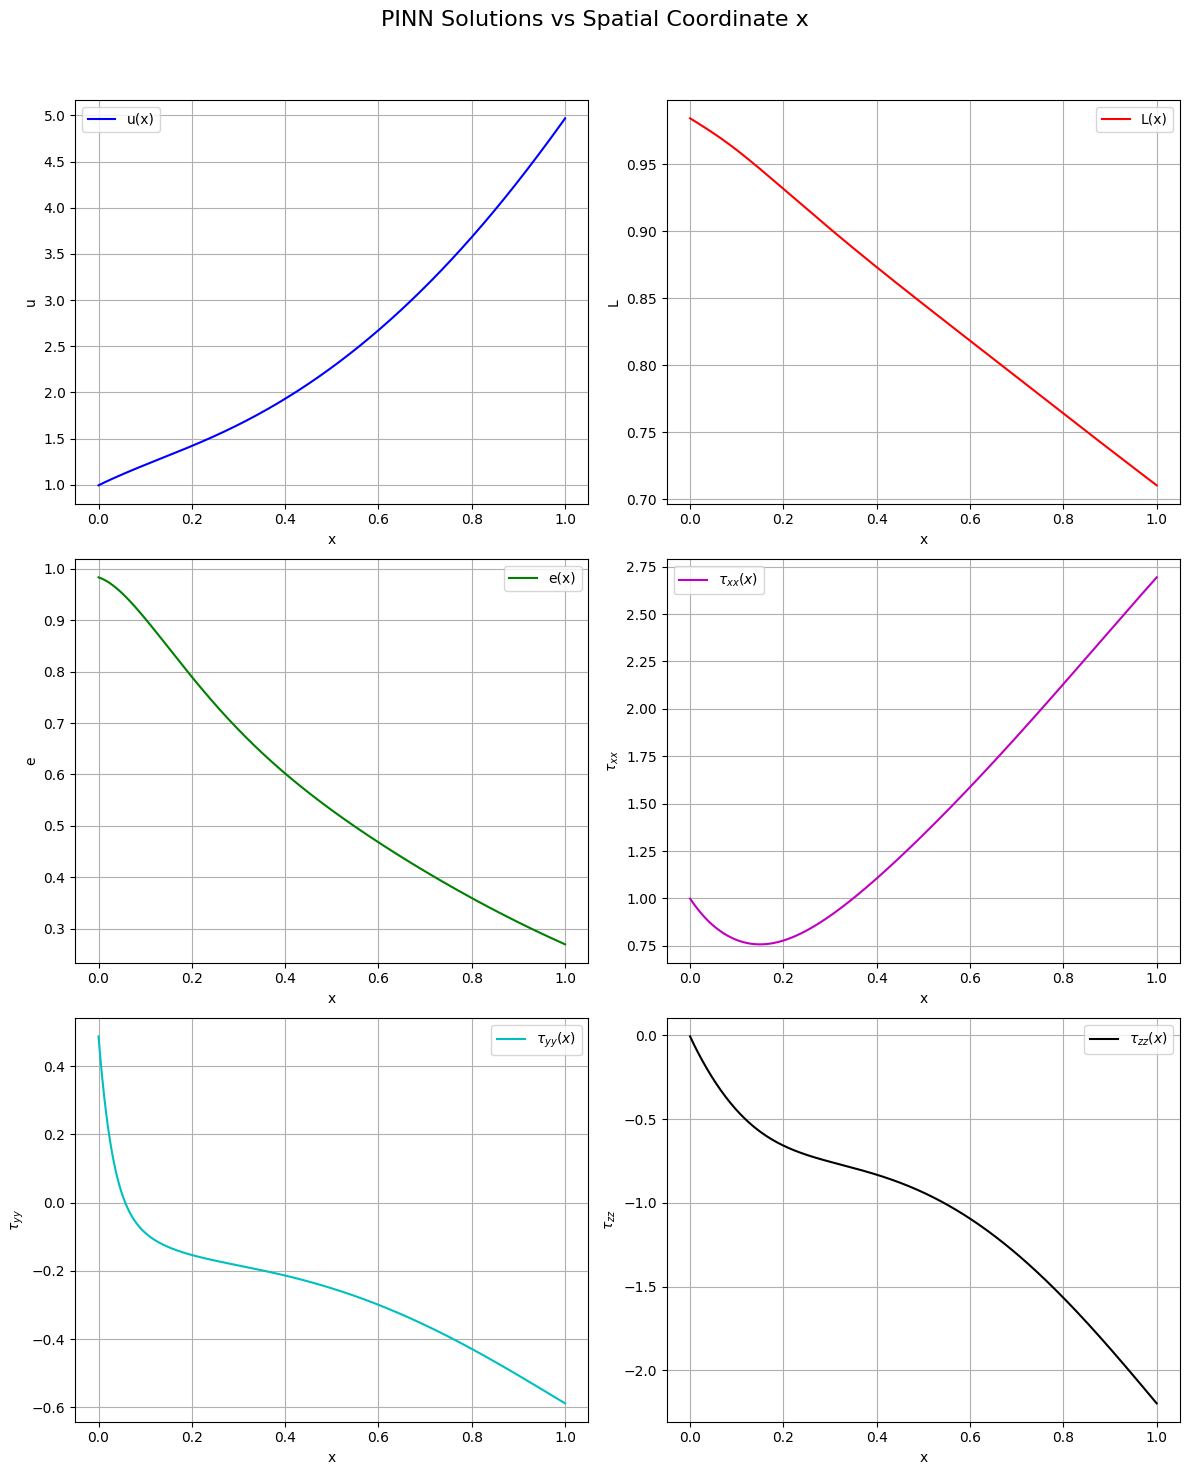

In [22]:
def plot_solutions(model, x_range=None):
    """
    Plot the PINN solutions for all variables separately.
    
    Parameters:
    model: Trained PINN model
    x_range: Optional tensor of x values, if None generates default range
    """
    # Set model to evaluation mode
    model.eval()
    
    # Generate x points if not provided
    if x_range is None:
        x_range = torch.linspace(0.0, 1.0, 500).reshape(-1, 1)  # [1000,1]
    
    # Ensure x_range requires no gradient for plotting
    with torch.no_grad():
        # Get predictions
        outputs = model(x_range)  # [1000,6]
        u, L, e, tau_xx, tau_yy, tau_zz = torch.split(outputs, 1, dim=1)  # Each: [1000,1]
        
        # Convert to numpy for plotting
        x_np = x_range.numpy().flatten()  # [1000]
        u_np = u.numpy().flatten()        # [1000]
        L_np = L.numpy().flatten()        # [1000]
        e_np = e.numpy().flatten()        # [1000]
        tau_xx_np = tau_xx.numpy().flatten()  # [1000]
        tau_yy_np = tau_yy.numpy().flatten()  # [1000]
        tau_zz_np = tau_zz.numpy().flatten()  # [1000]
    
    # Create separate plots for each variable
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle('PINN Solutions vs Spatial Coordinate x', fontsize=16)
    
    # Plot u
    axs[0, 0].plot(x_np, u_np, 'b-', label='u(x)')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('u')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    
    # Plot L
    axs[0, 1].plot(x_np, L_np, 'r-', label='L(x)')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('L')
    axs[0, 1].grid(True)
    axs[0, 1].legend()
    
    # Plot e
    axs[1, 0].plot(x_np, e_np, 'g-', label='e(x)')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('e')
    axs[1, 0].grid(True)
    axs[1, 0].legend()
    
    # Plot tau_xx
    axs[1, 1].plot(x_np, tau_xx_np, 'm-', label=r'$\tau_{xx}(x)$')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel(r'$\tau_{xx}$')
    axs[1, 1].grid(True)
    axs[1, 1].legend()
    
    # Plot tau_yy
    axs[2, 0].plot(x_np, tau_yy_np, 'c-', label=r'$\tau_{yy}(x)$')
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel(r'$\tau_{yy}$')
    axs[2, 0].grid(True)
    axs[2, 0].legend()
    
    # Plot tau_zz
    axs[2, 1].plot(x_np, tau_zz_np, 'k-', label=r'$\tau_{zz}(x)$')
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel(r'$\tau_{zz}$')
    axs[2, 1].grid(True)
    axs[2, 1].legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust top margin for suptitle
    plt.show()

# Example usage after training:
# Add this after the training loop in your original code
if __name__ == "__main__":
    # After training loop
    plot_solutions(model)

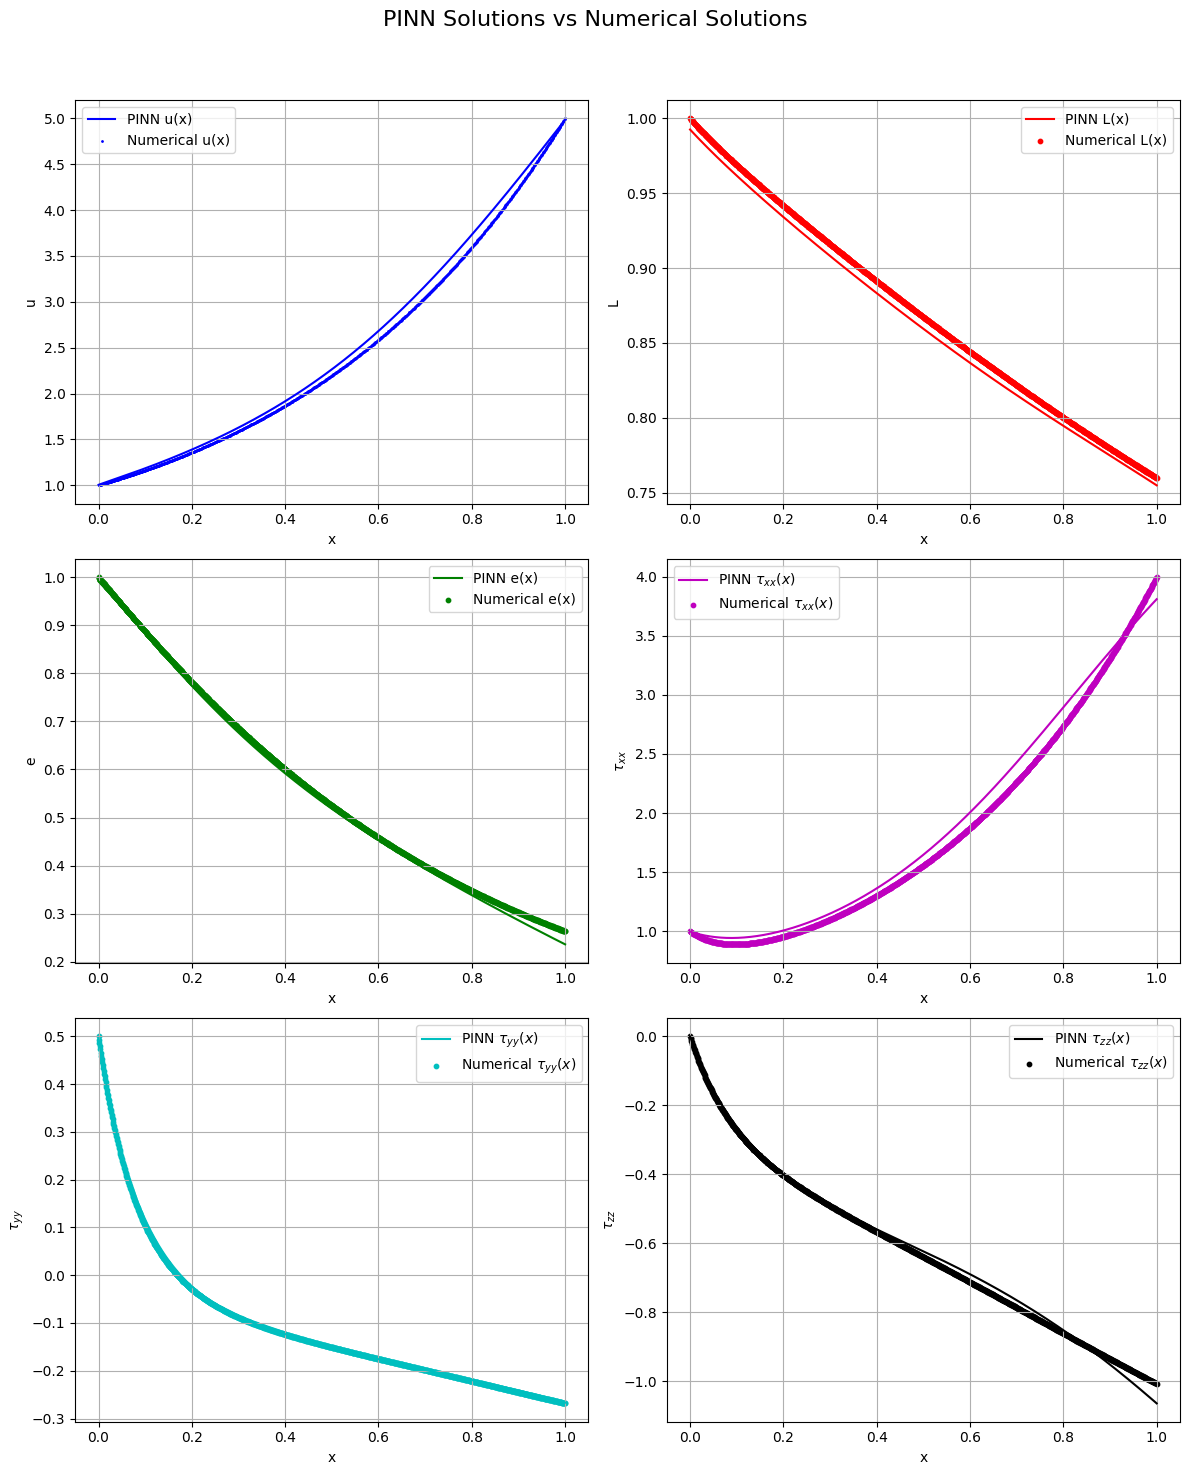

In [63]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os 

def plot_solutions_with_numerical(model, x_range=None, numerical_df=None):
    """
    Plot the PINN solutions for all variables alongside numerical solutions.

    Parameters:
    model: Trained PINN model
    x_range: Optional tensor of x values, if None generates default range
    numerical_df: DataFrame containing numerical solutions
    """
    # Set model to evaluation mode
    model.eval()

    # Generate x points if not provided
    if x_range is None:
        x_range = torch.linspace(0.0, 1.0, 1000).reshape(-1, 1)  # [1000,1]

    # Ensure x_range requires no gradient for plotting
    with torch.no_grad():
        # Get predictions
        outputs = model(x_range)  # [1000,6]
        u, L, e, tau_xx, tau_yy, tau_zz = torch.split(outputs, 1, dim=1)  # Each: [1000,1]

        # Convert to numpy for plotting
        x_np = x_range.numpy().flatten()  # [1000]
        u_np = u.numpy().flatten()        # [1000]
        L_np = L.numpy().flatten()        # [1000]
        e_np = e.numpy().flatten()        # [1000]
        tau_xx_np = tau_xx.numpy().flatten()  # [1000]
        tau_yy_np = tau_yy.numpy().flatten()  # [1000]
        tau_zz_np = tau_zz.numpy().flatten()  # [1000]

    # Extract numerical solutions from DataFrame
    x_numerical = numerical_df["x"].values
    L_numerical = numerical_df["L"].values
    u_numerical = numerical_df["u"].values
    e_numerical = numerical_df["e"].values
    tau_xx_numerical = numerical_df["tau_xx"].values
    tau_yy_numerical = numerical_df["tau_yy"].values
    tau_zz_numerical = numerical_df["tau_zz"].values

    # Create separate plots for each variable
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle('PINN Solutions vs Numerical Solutions', fontsize=16)

    # Plot u
    axs[0, 0].plot(x_np, u_np, 'b-', label='PINN u(x)')
    axs[0, 0].scatter(x_numerical, u_numerical, color='b', marker='o', label='Numerical u(x)', s=1)
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('u')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Plot L
    axs[0, 1].plot(x_np, L_np, 'r-', label='PINN L(x)')
    axs[0, 1].scatter(x_numerical, L_numerical, color='r', marker='o', label='Numerical L(x)', s=10)
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('L')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot e
    axs[1, 0].plot(x_np, e_np, 'g-', label='PINN e(x)')
    axs[1, 0].scatter(x_numerical, e_numerical, color='g', marker='o', label='Numerical e(x)', s=10)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('e')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Plot tau_xx
    axs[1, 1].plot(x_np, tau_xx_np, 'm-', label=r'PINN $\tau_{xx}(x)$')
    axs[1, 1].scatter(x_numerical, tau_xx_numerical, color='m', marker='o', label=r'Numerical $\tau_{xx}(x)$', s=10)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel(r'$\tau_{xx}$')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    # Plot tau_yy
    axs[2, 0].plot(x_np, tau_yy_np, 'c-', label=r'PINN $\tau_{yy}(x)$')
    axs[2, 0].scatter(x_numerical, tau_yy_numerical, color='c', marker='o', label=r'Numerical $\tau_{yy}(x)$', s=10)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel(r'$\tau_{yy}$')
    axs[2, 0].grid(True)
    axs[2, 0].legend()

    # Plot tau_zz
    axs[2, 1].plot(x_np, tau_zz_np, 'k-', label=r'PINN $\tau_{zz}(x)$')
    axs[2, 1].scatter(x_numerical, tau_zz_numerical, color='k', marker='o', label=r'Numerical $\tau_{zz}(x)$', s=10)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel(r'$\tau_{zz}$')
    axs[2, 1].grid(True)
    axs[2, 1].legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust top margin for suptitle
    plt.show()

file_path = os.getcwd() + "\\efc_numerical_De0.1_ep0.1_psi0.1_D5.csv"
df = pd.read_csv(file_path)
# Example usage:
plot_solutions_with_numerical(model, numerical_df=df)

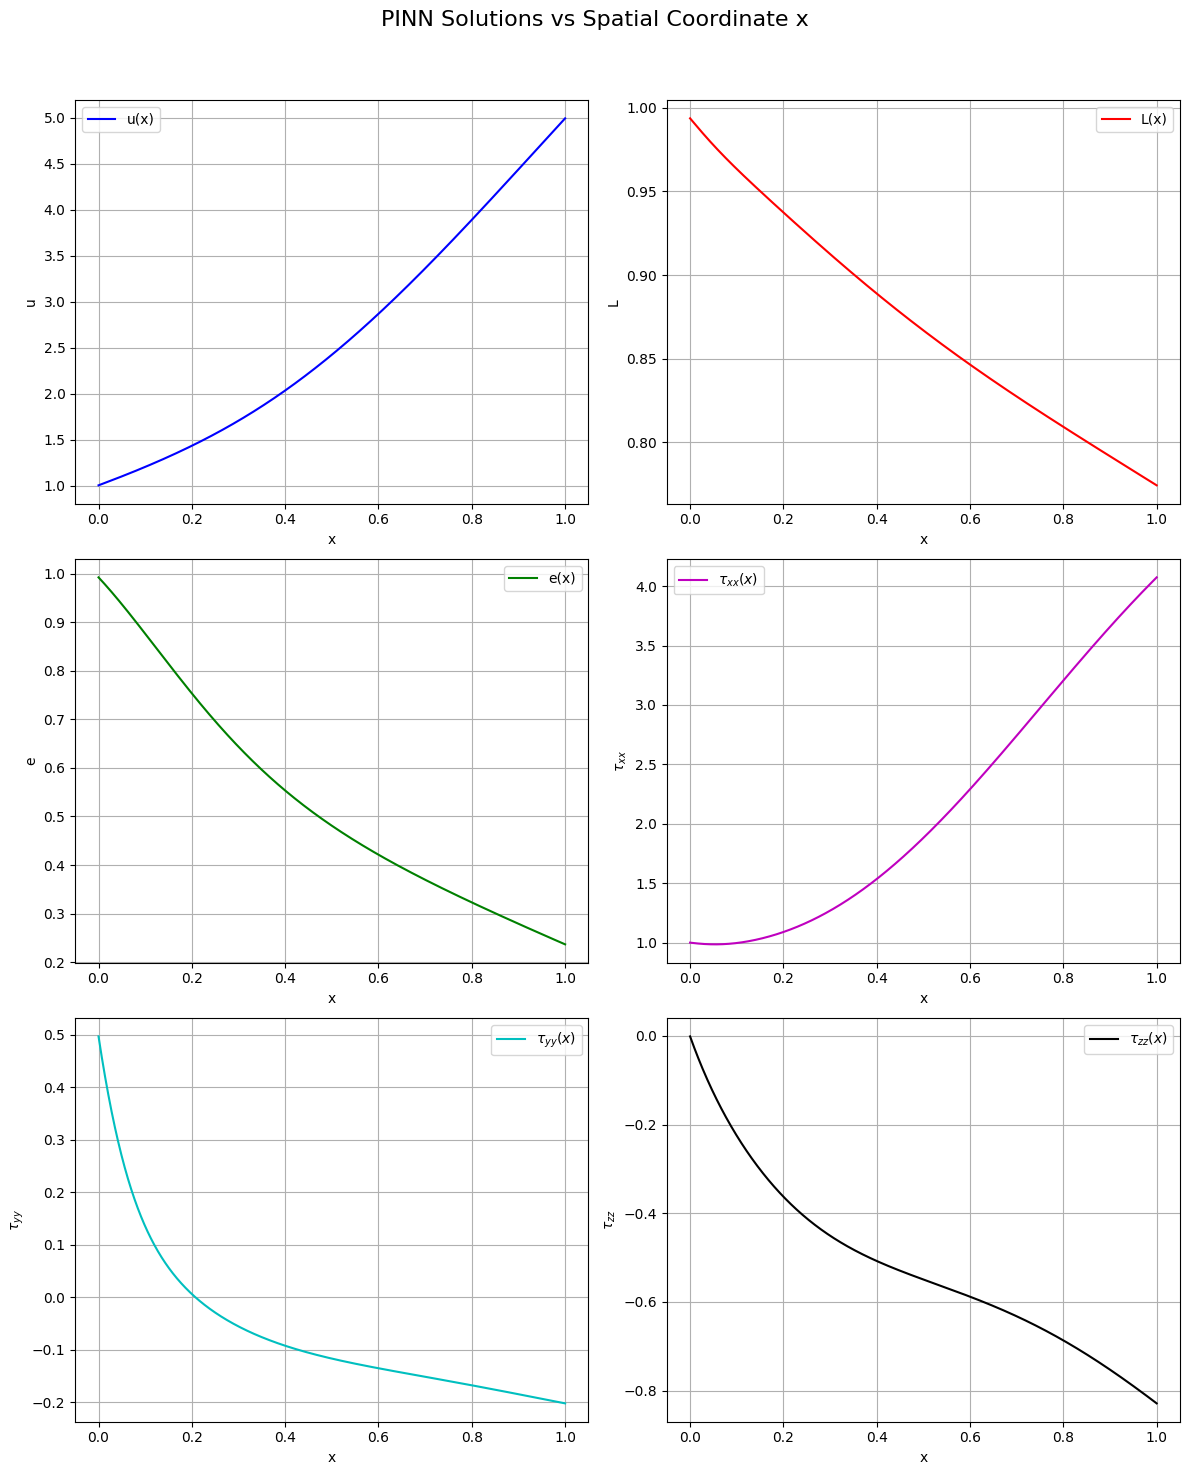

In [10]:
def plot_solutions(model, x_range=None):
    """
    Plot the PINN solutions for all variables separately.
    
    Parameters:
    model: Trained PINN model
    x_range: Optional tensor of x values, if None generates default range
    """
    # Set model to evaluation mode
    model.eval()
    
    # Generate x points if not provided
    if x_range is None:
        x_range = torch.linspace(0.0, 1.0, 1000).reshape(-1, 1)  # [1000,1]
    
    # Ensure x_range requires no gradient for plotting
    with torch.no_grad():
        # Get predictions
        outputs = model(x_range)  # [1000,6]
        u, L, e, tau_xx, tau_yy, tau_zz = torch.split(outputs, 1, dim=1)  # Each: [1000,1]
        
        # Convert to numpy for plotting
        x_np = x_range.numpy().flatten()  # [1000]
        u_np = u.numpy().flatten()        # [1000]
        L_np = L.numpy().flatten()        # [1000]
        e_np = e.numpy().flatten()        # [1000]
        tau_xx_np = tau_xx.numpy().flatten()  # [1000]
        tau_yy_np = tau_yy.numpy().flatten()  # [1000]
        tau_zz_np = tau_zz.numpy().flatten()  # [1000]
    
    # Create separate plots for each variable
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle('PINN Solutions vs Spatial Coordinate x', fontsize=16)
    
    # Plot u
    axs[0, 0].plot(x_np, u_np, 'b-', label='u(x)')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('u')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    
    # Plot L
    axs[0, 1].plot(x_np, L_np, 'r-', label='L(x)')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('L')
    axs[0, 1].grid(True)
    axs[0, 1].legend()
    
    # Plot e
    axs[1, 0].plot(x_np, e_np, 'g-', label='e(x)')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('e')
    axs[1, 0].grid(True)
    axs[1, 0].legend()
    
    # Plot tau_xx
    axs[1, 1].plot(x_np, tau_xx_np, 'm-', label=r'$\tau_{xx}(x)$')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel(r'$\tau_{xx}$')
    axs[1, 1].grid(True)
    axs[1, 1].legend()
    
    # Plot tau_yy
    axs[2, 0].plot(x_np, tau_yy_np, 'c-', label=r'$\tau_{yy}(x)$')
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel(r'$\tau_{yy}$')
    axs[2, 0].grid(True)
    axs[2, 0].legend()
    
    # Plot tau_zz
    axs[2, 1].plot(x_np, tau_zz_np, 'k-', label=r'$\tau_{zz}(x)$')
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel(r'$\tau_{zz}$')
    axs[2, 1].grid(True)
    axs[2, 1].legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust top margin for suptitle
    plt.show()

# Example usage after training:
# Add this after the training loop in your original code
if __name__ == "__main__":
    # After training loop
    plot_solutions(model)